In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx

In [2]:
from featureExtraction import featureExtraction
# from bundle_adjustment import bundleAdjuster


In [3]:
def loadImages(img_dir):
    img_names = os.listdir(img_dir)
    img_list = []
    # Load images
    for img_name in img_names:
        img = cv.imread(img_dir + img_name)
        img_list.append(img)

    return img_list

    

In [4]:
img_dir = "./data/setSmall/"
img_list = loadImages(img_dir)


In [5]:
fe = featureExtraction(img_list,method="FLANN")

In [6]:
fe.run()

Extracting SIFT features...
Generating matches...
Processing matches...
Computing homographies...
Computing adjacency matrix...


#### Visualizing the network

In [7]:
def display_network(adjacency_matrix):
    G = nx.Graph(adjacency_matrix)
    nx.draw(G, with_labels=True, font_weight='bold')
    plt.show()

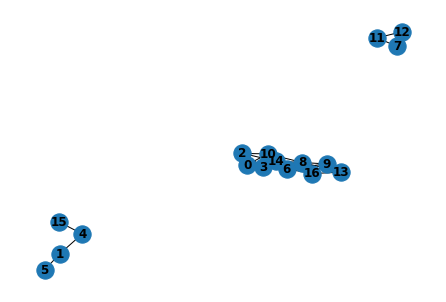

In [8]:
display_network(fe.adjacency_matrix)

In [20]:
import cv2 as cv
import numpy as np
import networkx as nx
import scipy.sparse.csgraph as csgraph


class bundleAdjuster():

    def __init__(self,matches,homographyMatches,images,adjacency_matrix):
        self.homographyMatches = homographyMatches
        self.images = images
        self.num_images = len(images)
        self.adjacency_matrix = adjacency_matrix
        self.matches = matches
        self.connected_components=nx.connected_components(nx.Graph(self.adjacency_matrix))
        self.f=1
        self.cameraMatrix = np.array([[self.f,0,0],[0,self.f,0],[0,0,1]])
        self.R=np.eye(3)
        self.camera_params=[] # camera params for each connected component
    
    def dijkstra(self, source, component):
        # source is the source node
        # component is the connected component
        # this function returns the order of images in the connected component
        # we will use the adjacency matrix to get the order of images in the connected component
        parents = csgraph.dijkstra(self.adjacency_matrix, indices=source, return_predecessors=True)[1]
        order_of_images = []
        visited = set()  # to keep track of visited nodes
        for i in component:
            if i not in visited:
                visited.add(i)
                order_of_images.append(i)
                while i != source:
                    i = parents[i]
                    if i not in visited:
                        visited.add(i)
                        order_of_images.append(i)
        return order_of_images

        # order is R to L
        
        
    
    def bundleAdjustment(self):
        
        # self.matches is matrix of size (num_images x num_images) where each element is a list of matches between two images
        # self.homographyMatches is matrix of size (num_images x num_images) where each element contains homography matrix between two images in case of valid match
        # self.images is a list of images
        # self.num_images is the number of images
        # self.adjacency_matrix is num_images x num_images matrix where each element is 1 if there is a match between two images and 0 otherwise
        # self.connected_components is a list of connected components in the graph of matches
        # now for each connected component, we will perform bundle adjustment to get rotation and focal length
        # we will use the first image in the connected component as the reference image
        for component in self.connected_components:
            component=list(component)
            R=np.eye(3)
            f=1
            # start with these values for focal length and rotation
            # update these values using bundle adjustment
            # we need to find the order of images in the connected component
            # we will use the first image in the connected component as the reference image

            # get the order of images in the connected component using bfs
            # we will use the first image in the connected component as the reference image
            # we will use the adjacency matrix to get the order of images in the connected component
            # we will use the bfs function to get the order of images in the connected component
            order_of_images=self.dijkstra(component[0],component)
            print(order_of_images)  
            # plot the images in order
            plt.imshow(self.images[order_of_images[2]])
            plt.show()

            

[0, 2, 3, 6, 8, 9, 10, 13, 16, 14]


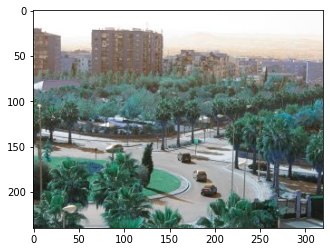

[1, 4, 5, 15]


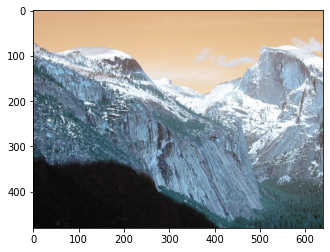

[11, 12, 7]


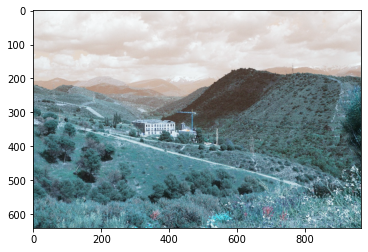

In [21]:
matches=fe.matches
homographies=fe.homographies
images=fe.image_list
adjacency_matrix=fe.adjacency_matrix

# get all connected components
# connected_components = nx.connected_components(nx.Graph(fe.adjacency_matrix))
ba=bundleAdjuster(matches,homographies,images,adjacency_matrix)
ba.bundleAdjustment()
 